In [1264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from shapely.ops import split,nearest_points
from shapely.geometry import LineString,Polygon,Point, MultiPolygon
import networkx as nx
from shapely.affinity import translate
from newton_multidimention import Optimize_Drone_Position_Euclidean_cap_1
from gradient import optimize_dp_using_gradient_method

import matplotlib.image as mpimg
background = mpimg.imread('./maps/map.png')

## Creating delivary locations

In [1265]:
def create_delivary(x,y,n, seed_value = None):
    if seed_value != None:
        random.seed(seed_value)

    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for i in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append(tuple([x_loc, y_loc]))

    return loc

## Visualizations

In [1266]:
def primary_plot(delivary_loc, obstacles):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    delivary_loc = np.array(delivary_loc)
    plt.grid(True)
    plt.scatter(delivary_loc[:,0], delivary_loc[:,1], label="Delivary loc")

    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        # points = np.array(points)
        # plt.scatter(points[:,0], points[:,1])
        plt.fill(x,y,color="red", alpha = 0.3)
    # plt.legend()

In [1267]:
def plot_dp(dp, delivary_loc, obstacles):
    primary_plot(delivary_loc, obstacles)
    plt.scatter(dp[0], dp[1], marker='^', c="black", label = "DP")
    # plt.legend()
    # plt.show()

In [1268]:
def plot_initial_route(dp, delivary_loc, obstacles, route, title=None):
    plot_dp(dp, delivary_loc, obstacles)
    for i in range(len(route)-1):
        f_pt = np.array([route[i][0], route[i+1][0]])
        s_pt = np.array([route[i][1], route[i+1][1]])
        plt.plot(f_pt, s_pt, c="gray")
    if title != None:
        plt.title(title)
    # plt.show()

## Calculate DP

In [1269]:
def calculate_dp(delivary_loc):
    x = [i for i,j in delivary_loc]
    y = [j for i,j in delivary_loc]

    x_axis = np.mean(x)
    y_axis = np.mean(y)

    return [x_axis, y_axis]

## Create Route

In [1270]:
def create_route(pts, extra):
    lst = pts.copy()
    idx = 0
    k = len(lst)
    for i in range(k):
        lst.insert(idx, extra)
        idx +=2

    lst.append(extra)
    return lst

## Distance Calculate

In [1271]:
def euc_distance(pt1, pt2):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.sqrt(np.sum((pt2 - pt1)**2))

In [1272]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += euc_distance(pts[i], pts[i+1])

    return sum

## Check for obstacles

In [1273]:
def create_polygon(points):
    coords = []

    for pt in points:
        coords.append(pt)

    obs_polygon = Polygon(coords)
    return obs_polygon

In [1274]:
def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle_id, points in obstacles.items():
    obstacle = create_polygon(points)
    if line.intersects(obstacle):
      return True

  return False

In [1275]:
def detect_obstacle(route, obstacles):
    for i in range(0,len(route)-1,2):
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            return True
    return False

In [1276]:
def relocate_dp(dp, obstacle_polygon):
    near_point = nearest_points(obstacle_polygon.exterior, dp)

    near_point = near_point[0].coords[0]

    return near_point

In [1277]:
obs = Polygon(
    [(0, 0), (0, 1), (1, 1), (1, 0)]
)

list(obs.exterior.coords)

[(0.0, 0.0), (0.0, 1.0), (1.0, 1.0), (1.0, 0.0), (0.0, 0.0)]

In [1278]:
def varify_dp(dp, obstacles):
    final_dp = None
    cur_dp = Point([dp[0],dp[1]])

    for obs_id, obstacle in obstacles.items():
        obstacle_polygon = create_polygon(obstacle)
        
        if obstacle_polygon.contains(cur_dp):
            final_dp = list(obstacle_polygon.exterior.coords)
            break
    
    return [dp] if final_dp == None else final_dp

## Generate Intermediate Point

In [1279]:
def is_obstacle_free(line, obstacles):
    for obs_id, obs in obstacles.items():
        if line.intersects(obs):
            return False
    return True

In [1280]:
def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = {id_: create_polygon(points) for id_, points in obstacles.items()}
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle_id, obstacle in obstacle_polygons.items():
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
            if target_obs == None and len(intersections)>0:
                target_obs = obstacle

    # If no intersections found, return None
    if not intersections:
        return None

    # Choose the intersection with the smallest sum of distances to A and B
    inter_x = sum(inter.x for inter in intersections)/len(intersections)
    inter_y = sum(inter.y for inter in intersections)/len(intersections)
    nearest_inter = Point(inter_x, inter_y)

    interval = 0.3
    increment = 0.3
    limit = 2.5

    while interval < limit:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        # if not left_side.intersects(target_obs):
        if is_obstacle_free(left_side, obstacle_polygons):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs_id, obs in obstacle_polygons.items():
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        # if not right_side.intersects(target_obs):
        if is_obstacle_free(right_side, obstacle_polygons):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs_id, obs in obstacle_polygons.items():
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        # if not up_side.intersects(target_obs):
        if is_obstacle_free(up_side, obstacle_polygons):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs_id, obs in obstacle_polygons.items():
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        # if not down_side.intersects(target_obs):
        if is_obstacle_free(down_side, obstacle_polygons):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs_id, obs in obstacle_polygons.items():
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += increment

    return None

In [1281]:
def adv_route(route, dp, obstacles):
    ans_route = []
    for i in range(len(route)-1):
        if route[i] != dp:
            continue
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            intermediate_point = find_inter_point(route[i], route[i+1], obstacles)
            if intermediate_point == None:
                return route, "fail"
            ans_route.append(route[i])
            ans_route.append(intermediate_point)
            ans_route.append(route[i+1])
            ans_route.append(intermediate_point)
        else:
            ans_route.append(route[i])
            ans_route.append(route[i+1])

    ans_route.append(dp)
    return ans_route, "pass"

## A* Algorithm

In [1282]:
def line_intersect_2(line, obstacle):
    parts = split(obstacle, line)

    count = len([geoms for geoms in parts.geoms])

    return count != 1

In [1283]:
def line_intersect(line, obstacle):
    points = line.intersection(obstacle)
    
    if(type(points) != Point and type(points) != LineString):
        return True
    
    if len(points.coords) == 0 or len(points.coords) == 1:
        return False

    points = [pt for pt in points.coords]
    obstacle_points = [pt for pt in obstacle.exterior.coords[:-1]]

    try :
        index_list = [obstacle_points.index(i) for i in points]
    except:
        return True

    for i in range(0,len(index_list)-1,2):
        if not (abs(index_list[i] - index_list[i+1]) == 1 or abs(index_list[i] - index_list[i+1]) == len(obstacle_points)-1):
            return True

    return False

In [1284]:
def check_for_obstacle(point_1, point_2, obstacles):
    line = LineString([point_1, point_2])

    for obs_id, obs in obstacles.items():
        # if line.intersects(obs):
        if line_intersect_2(line, obs):
            return True
    return False

In [1285]:
def scale_polygon(polygon, scale_factor = 0.99):
    centroid = polygon.centroid

    # Define the scale factor to reduce the distance
    scale_factor = scale_factor  # You can adjust this value to control the reduction

    # Create a new polygon with reduced distance from the centroid
    new_points = [translate(Point(p), xoff=(centroid.x - p[0]) * (1 - scale_factor), yoff=(centroid.y - p[1]) * (1 - scale_factor)).coords[0] for p in polygon.exterior.coords]
    new_polygon = Polygon(new_points)

    return new_polygon

In [1286]:
def create_shortest_path(point_1, point_2, obstacles):
    try:
        obstacle_polygon = {ob_id : create_polygon(obs) for ob_id, obs in obstacles.items()}
        route_line = LineString([point_1, point_2])

        # print("Initial polygon ",obstacle_polygon)

        intersections = []
        for obstacle_id, obstacle in obstacle_polygon.items():
            if route_line.intersects(obstacle):
                for cord in range(len(obstacle.exterior.coords)-1):
                    intersections.append(obstacle.exterior.coords[cord])
        # Create a graph
        G = nx.Graph()

        # Add nodes for each point in the space
        G.add_node(tuple(point_1))

        for inter_point in intersections:
            G.add_node(tuple(inter_point))

        G.add_node(tuple(point_2))

        # Add edges between adjacent points (up, down, left, right)
        # for cur in G.nodes():
        #     for next in G.nodes():
        #         if cur == next:
        #             continue
        #         if not check_for_obstacle(cur, next, obstacle_polygon):
        #             G.add_edge(cur, next)
        for i in range(len(G.nodes()) - 1):
            for j in range(i+1, len(G.nodes())):
                cur = list(G.nodes())[i]
                next = list(G.nodes())[j]
                if not check_for_obstacle(cur, next, obstacle_polygon):
                    G.add_edge(cur, next)

        # Find the shortest path using A*
        start = tuple(point_1)
        goal = tuple(point_2)
        path = nx.astar_path(G, start, goal, heuristic=euc_distance)

        return path
    except Exception as e:
        print("Error in create_shortest_path, No obstacle free path found")
        return None

In [1287]:
def a_star_algo(route, dp, obstacles):
    ans_route = []
    for i in range(len(route)):
        if check_obstacle_in_line(dp,route[i], obstacles):
            new_path = create_shortest_path(dp, route[i], obstacles)
            if new_path == None:
                return route, "fail"
            for i in new_path:
                ans_route.append(i)
            for i in range(len(new_path)-2, 0, -1):
                ans_route.append(new_path[i])
        else:
            ans_route.append(dp)
            ans_route.append(route[i])

    ans_route.append(dp)
    return ans_route, "pass"

In [1288]:
def create_shortest_dijkstra_path(source, dest, obstacles):
    obstacles = {ob_id : create_polygon(obs) for ob_id, obs in obstacles.items()}

    G = nx.Graph()

    # connecting nodes
    G.add_node(tuple(source))

    for i in dest:
        G.add_node(tuple(i))

    for obs_id, obstacle in obstacles.items():
        for i in obstacle.exterior.coords:
            G.add_node(tuple(i))

    nodes = list(G.nodes())

    # connecting edges
    for i in range(0,len(nodes)-1):
        for j in range(i+1,len(nodes)):
            intersect = False
            for obs_id, obstacle in obstacles.items():
                if line_intersect_2(LineString([nodes[i],nodes[j]]),obstacle):
                    intersect = True
                    break
            if not intersect:
                G.add_edge(nodes[i],nodes[j], weight = euc_distance(nodes[i],nodes[j]))

    dijkstra_paths = nx.all_pairs_dijkstra(G)
    paths = []
    
    for target_node, (distances, path) in dijkstra_paths:
        if target_node == tuple(source):
            for loc_node in dest:
                cur_path = path[tuple(loc_node)]
                route = cur_path.copy()
                for i in range(len(cur_path)-2,0,-1):
                    # cur_path.append(cur_path[i])
                    route.append(cur_path[i])
                route.append(source)
                paths.extend(route)

    
    # pos = {node: node for node in G.nodes()}
    # nx.draw(G, pos, node_color='lightgray', with_labels=False)
    # nx.draw_networkx_nodes(G, pos, nodelist=[tuple(source)], node_color='green')
    # nx.draw_networkx_nodes(G, pos, nodelist=[des for des in dest], node_color='red')
    # nx.draw_networkx_edges(G, pos, edgelist=[(paths[i], paths[i+1]) for i in range(len(paths)-1)], edge_color='blue', width=2)
    # plt.title('Path Planning with Obstacle Avoidance')
    # plt.show()

    return paths, "pass"

## Creation of New DP

In [1289]:
def replace(lst, pt1, pt2):
    ls2 = lst.copy()
    for i in range(len(ls2)):
        if list(ls2[i]) == pt1:
            ls2[i] = pt2

    return ls2

In [1290]:
def frange(start, stop, step):
    while start < stop:
        yield round(start, 4)
        start += step

In [1291]:
def calculate_obstacle_free_dp(delivery_loc, obstacles, dp):
    
    # Initialize potential DP locations (covering the delivery point area)
    min_x = dp[0] - 1.0
    max_x = dp[0] + 1.0
    min_y = dp[1] - 1.0
    max_y = dp[1] + 1.0

    potential_dps = {}
    for x in frange(min_x, max_x, 0.2):
        for y in frange(min_y, max_y, 0.2):
            potential_dps[x,y] = {
                'route' : [],
                'distance' : 0
            }

    # Evaluate each potential DP and filter out those obstructed by obstacles
    for each_dp, value in potential_dps.items():
        first_route = create_route(delivery_loc, each_dp)
        last_route,msg = a_star_algo(first_route,each_dp,obstacles)
        if msg == 'pass':
            distance = total_dist(last_route)
        else:
            distance = float('inf')
        potential_dps[each_dp]['route'] = last_route
        potential_dps[each_dp]['distance'] = distance

    answer = min(potential_dps, key = lambda x : potential_dps[x]['distance'])

    return answer,potential_dps[answer]['route'],potential_dps[answer]['distance']

## Remove delivary points that are in the obstacles

In [1292]:
def remove_obstacle(delivary_loc, obstacles):
    obstacle_polygon = {obs_id : create_polygon(obs) for obs_id, obs in obstacles.items()}
    delivary_point = [Point([a,b]) for a,b in delivary_loc]
    final_point = []
    
    for point in delivary_point:
        flag = True
        for obs_id, obs in obstacle_polygon.items():
            if (point.intersects(obs)):
                flag = False
                break
        if flag:
            final_point.append(tuple([point.x, point.y]))
    return final_point

In [1293]:
def point_on_obstacle(obstacles, point):
    obstacle_polygon = [create_polygon(obs) for obs_id, obs in obstacles.items()]
    target_point = Point([point[0], point[1]])

    for obstacle in obstacle_polygon:
        if obstacle.contains(target_point):
            return obstacle
        
    return None

## Newton Multidimention

In [1294]:
def newton_points(dp, route):
    answer_list = []
    for i in range(1,len(route)-1):
        if (tuple(route[i-1]) == tuple(dp)) and (tuple(route[i]) != tuple(dp)):
            answer_list.append(tuple(route[i]))

    return answer_list

In [1295]:
def prone_dp(dp, obstacles, delivary_points):

    # if dp on obstacle return the corner points
    final_dp = point_on_obstacle(obstacles,dp)


    # if not then prone dp by newton multidimention
    newton_dp = list(Optimize_Drone_Position_Euclidean_cap_1(delivary_points, dp)[0])

    # check in newton_dp on obstacle
    final_newton_dp = point_on_obstacle(obstacles,newton_dp)

    if final_newton_dp == None:
        return [newton_dp]
    
    if final_dp == None and final_newton_dp != None:
        return [dp]

    if final_dp != None and final_newton_dp != None:
        return list(final_dp.exterior.coords)

## Geometric median

In [1296]:
def geometric_median(points, obstacles, eps=1e-5):
    # Initial guess for the geometric median
    guess = np.mean(points, axis=0)
    
    while True:
        # Calculate distances from current guess to all points
        distances = np.linalg.norm(points - guess, axis=1)
        
        # Avoid division by zero
        if np.sum(distances) == 0:
            return guess
        
        # Calculate weights as inverse distances
        weights = 1 / distances
        
        # Calculate weighted average
        new_guess = np.sum(points * weights[:, np.newaxis], axis=0) / np.sum(weights)
        
        # Check for convergence
        if np.linalg.norm(new_guess - guess) < eps:
            return new_guess
        
        # check if new_guess on obstacle
        if point_on_obstacle(obstacles, new_guess) != None:
            return new_guess
        
        print("next dp :", new_guess)
        guess = new_guess

## Main

In [1297]:
# pre-assumptions
x = [22.21, 88.45]
y = [34.45, 98.67]
n = 50
seed_value = 1

# answers
optimal_dp = []
optimal_route = []

# Creating delivary points
delivary_loc = create_delivary(x,y,n)

In [1298]:
# creating obstacles
obstacles = {
    0 : [[27.81, 90.75],[28.74, 91.42],[27.80, 93.15], [26.81, 92.53], [27.81, 90.75]],
    1 : [[23.11, 91.25], [24.81, 92.40], [24.21, 93.45], [22.51, 92.35],[23.11, 91.25]],
    2 : [[24.55, 88.60],[25.96, 89.55],[25.01, 91.35],[23.61, 90.32],[24.55, 88.60]],
    3 : [[25.60, 88.45], [27.42, 88.45],[26.92, 89.35],[25.60, 88.45]],
    4 : [[27.61, 88.45], [28.81, 88.45],[29.12, 88.66],[28.02, 90.45],[26.90, 89.57],[27.61, 88.45]],
    5 : [[25.33, 92.62], [25.86, 92.95], [25.21, 94.15], [24.69, 93.78], [25.33, 92.63]],
    6 : [[26.11, 93.05], [26.62, 93.35], [25.81, 94.65], [25.39, 94.35], [26.11, 93.05]],
    7 : [[26.72, 93.65], [27.32, 94.05], [26.69, 95.18], [26.10, 94.83], [26.72, 93.65]],
    8 : [[25.81, 95.40],[26.29, 95.70],[26.01, 96.20],[26.25, 96.37],[25.93, 96.94],[25.80, 96.84], [25.69, 97.01],[25.11, 96.65],[25.81, 95.40]],
    9 : [[23.90, 94.15], [24.91, 94.81], [24.48, 95.57],[23.48, 94.95],[23.90, 94.15]],
    10 : [[23.71, 98.67], [23.91, 98.26], [24.41, 98.67],[23.71, 98.67]],
    11 : [[31.81, 90.35], [32.51, 90.85], [32.21, 91.55], [32.03, 91.85], [34.31, 93.45], [32.69, 96.27],[30.99, 95.15], [32.21, 92.93],[30.89, 91.97],[31.81, 90.35]],
    12 : [[30.21, 96.00],[31.85, 97.11], [31.02, 98.55], [30.50, 98.26], [30.31, 98.53], [30.51, 98.67],[27.81, 98.67], [27.21, 98.28], [27.73, 97.43],[28.95, 98.25],[30.21, 96.00]]
}

# ensuring that we have exactly n delivary points outside obstacles
delivary_loc = remove_obstacle(delivary_loc, obstacles)
print(len(delivary_loc))

38


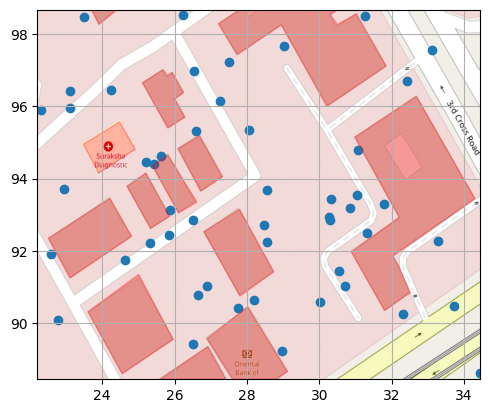

In [1299]:
extra_loc = []

while (len(extra_loc) != n - len(delivary_loc)):
    extra_loc = create_delivary(x,y,n - len(delivary_loc))
    extra_loc = remove_obstacle(extra_loc, obstacles)
delivary_loc.extend(extra_loc)

primary_plot(delivary_loc, obstacles)

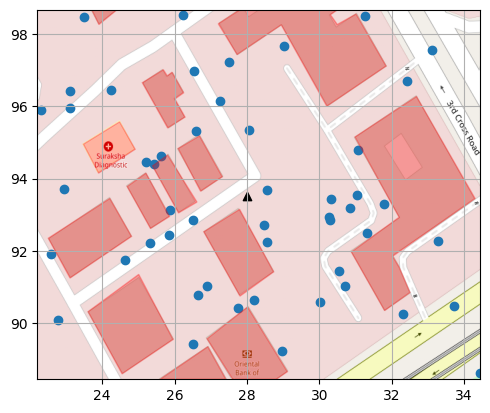

In [1300]:
# creating initial dp
initial_dp = calculate_dp(delivary_loc.copy())
# initial_dp = [28.52, 93.54]

# visualize dp
plot_dp(initial_dp, delivary_loc, obstacles)

*calculate total distance from the initial dp*

In [1301]:
# calculate route
initial_route = create_route(delivary_loc.copy(),initial_dp)

for i in initial_route:
    print(i,"->",end=" ")
print("End")

[27.994194987405304, 93.52291553935748] -> (27.76322433984199, 90.42141345377871) -> [27.994194987405304, 93.52291553935748] -> (26.648730691896755, 90.77135068579162) -> [27.994194987405304, 93.52291553935748] -> (31.255485901707296, 98.48498611323708) -> [27.994194987405304, 93.52291553935748] -> (26.231634368341002, 98.52138396591022) -> [27.994194987405304, 93.52291553935748] -> (33.12893733822822, 97.55425062508894) -> [27.994194987405304, 93.52291553935748] -> (30.860650059859935, 93.17513416267393) -> [27.994194987405304, 93.52291553935748] -> (27.24822315095515, 96.13792720202636) -> [27.994194987405304, 93.52291553935748] -> (22.78603599473748, 90.0869087718655) -> [27.994194987405304, 93.52291553935748] -> (28.062585599937016, 95.34882724999622) -> [27.994194987405304, 93.52291553935748] -> (25.8544350103765, 92.43002494973655) -> [27.994194987405304, 93.52291553935748] -> (26.500944095863055, 89.43798851217012) -> [27.994194987405304, 93.52291553935748] -> (22.30399356465237

Initial Distance : 383.412440165084


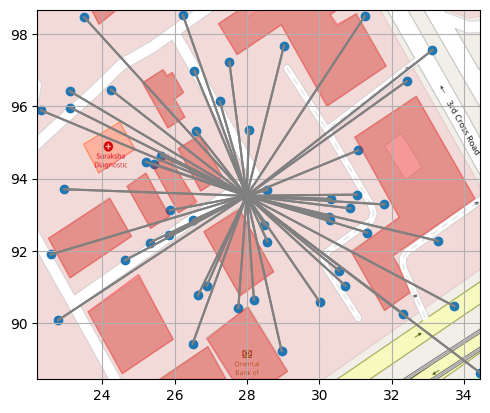

In [1302]:
# calculating distance
initial_dist = total_dist(initial_route)

print("Initial Distance :",initial_dist)

# Visualization
plot_initial_route(initial_dp, delivary_loc, obstacles, initial_route)

In [1303]:
# change dp location if dp on obstacle
calc_dp = varify_dp(initial_dp.copy(), obstacles)

*check for obstacles in the path, if no obstacle then it is optimal dp and optimal path*

--------------------------------------------------
Obstacle avoidance =>
Dp = [27.994194987405304, 93.52291553935748]
Route = [(27.994194987405304, 93.52291553935748), (28.74, 91.42), (27.76322433984199, 90.42141345377871), (28.74, 91.42), [27.994194987405304, 93.52291553935748], (27.994194987405304, 93.52291553935748), (26.81, 92.53), (26.648730691896755, 90.77135068579162), (26.81, 92.53), [27.994194987405304, 93.52291553935748], (27.994194987405304, 93.52291553935748), (31.85, 97.11), (31.255485901707296, 98.48498611323708), (31.85, 97.11), [27.994194987405304, 93.52291553935748], (27.994194987405304, 93.52291553935748), (26.231634368341002, 98.52138396591022), [27.994194987405304, 93.52291553935748], (27.994194987405304, 93.52291553935748), (33.12893733822822, 97.55425062508894), [27.994194987405304, 93.52291553935748], (27.994194987405304, 93.52291553935748), (30.860650059859935, 93.17513416267393), [27.994194987405304, 93.52291553935748], (27.994194987405304, 93.52291553935748), 

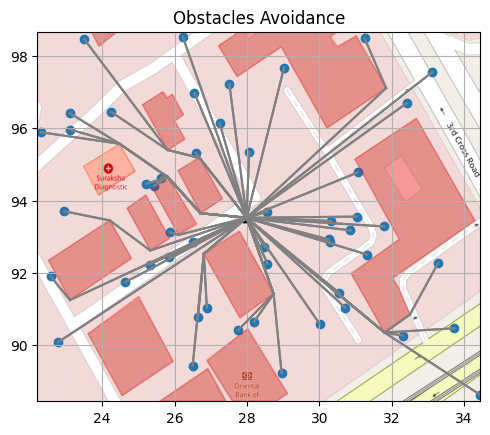

In [1304]:
optimal_dp = None
optimal_route = None
min_distance = float('inf')

for dp in calc_dp:
    new_route, msg = create_shortest_dijkstra_path(dp, delivary_loc.copy(), obstacles)
    if msg == "pass":
        new_dist = total_dist(new_route)
    else:
        new_dist = float('inf')
        new_route = initial_route.copy()

    if new_dist < min_distance:
        min_distance = new_dist
        optimal_dp = dp
        optimal_route = new_route

print("-"*50)
print("Obstacle avoidance =>")
print("Dp =",dp)
print("Route =",new_route)
print("Total distance =",min_distance)
print("-"*50)

plot_initial_route(optimal_dp,delivary_loc, obstacles, optimal_route, "Obstacles Avoidance")

#### <font color="orange">DP Pruning</font>

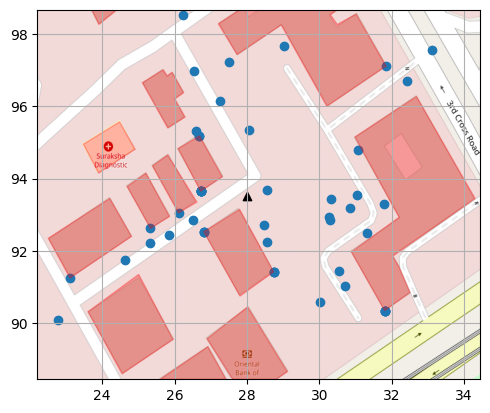

In [1305]:
newton_points = newton_points(optimal_dp, optimal_route.copy())

plot_dp(optimal_dp, newton_points, obstacles)

In [1306]:
# optimized_dp = optimize_dp_using_gradient_method(newton_points)

# print("Enhanced dp =",optimized_dp)
# print("Previous dp =",optimal_dp)

In [1307]:
# optimized_route = replace(optimal_route.copy(), optimal_dp, optimized_dp)
# optimized_route, msg = create_shortest_dijkstra_path(optimized_dp, delivary_loc.copy(), obstacles)


# plot_initial_route(optimized_dp,delivary_loc, obstacles, optimized_route)

In [1308]:
# gradient_dist = total_dist(optimized_route)

# print("Distance =",gradient_dist)

## Geometric median

In [1309]:
geometric_dp = geometric_median(newton_points.copy(), obstacles)

print("Enhanced dp =",geometric_dp)
print("Previous dp =",optimal_dp)

next dp : [28.24778389 93.26784564]
next dp : [28.16593463 93.22838822]
next dp : [28.11934361 93.21839376]
next dp : [28.09132701 93.21831132]
next dp : [28.07375499 93.22060385]
next dp : [28.06244878 93.22291353]
next dp : [28.05507011 93.22469889]
next dp : [28.0502177  93.22596085]
next dp : [28.04701357 93.22682041]
next dp : [28.04489322 93.22739647]
next dp : [28.0434884  93.22777986]
next dp : [28.04255705 93.22803429]
next dp : [28.04193937 93.22820298]
next dp : [28.04152964 93.2283148 ]
next dp : [28.04125782 93.22838892]
next dp : [28.04107747 93.22843807]
next dp : [28.04095781 93.22847067]
next dp : [28.04087842 93.22849229]
next dp : [28.04082574 93.22850663]
next dp : [28.04079078 93.22851615]
next dp : [28.04076759 93.22852246]
next dp : [28.0407522  93.22852665]
next dp : [28.04074199 93.22852943]
Enhanced dp = [28.04073521 93.22853127]
Previous dp = [27.994194987405304, 93.52291553935748]


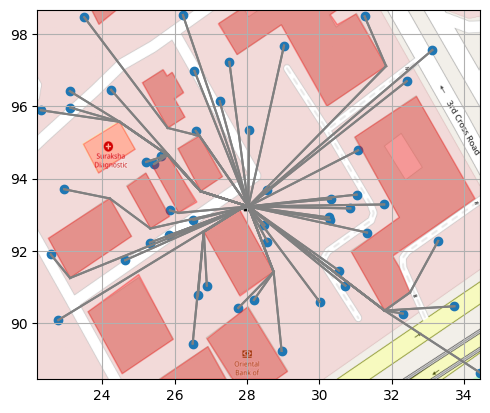

In [1310]:
geometric_route, msg = create_shortest_dijkstra_path(geometric_dp, delivary_loc.copy(), obstacles)

plot_initial_route(geometric_dp,delivary_loc, obstacles, geometric_route)

In [1311]:
geometric_dist = total_dist(geometric_route)

print("Distance =",geometric_dist)

Distance = 398.079868885827


## Result

Previous distance : 399.3538807767996
geometric distance : 398.079868885827
----------------------------------------------------------------------------------------------------


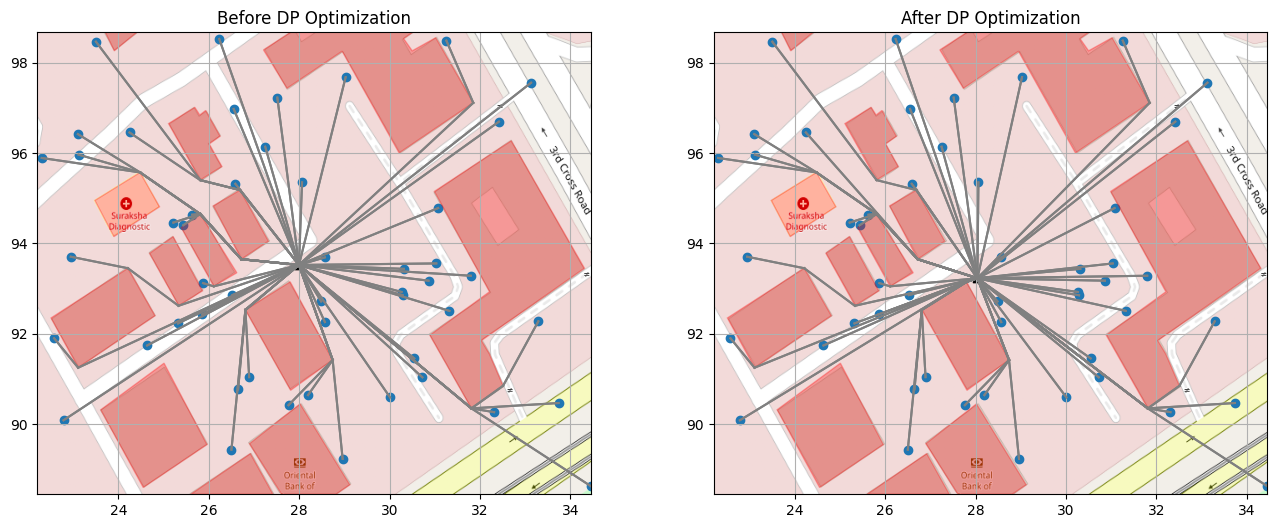

In [1312]:
print("Previous distance :", min_distance)
print("geometric distance :", geometric_dist)
# print("gradient distance :", gradient_dist)
print("-"*100)

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plot_initial_route(optimal_dp,delivary_loc.copy(), obstacles, optimal_route, "Before DP Optimization")
plt.subplot(1,2,2)
plot_initial_route(geometric_dp,delivary_loc.copy(), obstacles, geometric_route, "After DP Optimization")
plt.show()

In [1313]:
if geometric_dist < min_distance:
    final_dp = geometric_dp
    final_route = geometric_route
    final_distance = geometric_dist
else:
    final_dp = optimal_dp
    final_route = optimal_route
    final_distance = min_distance

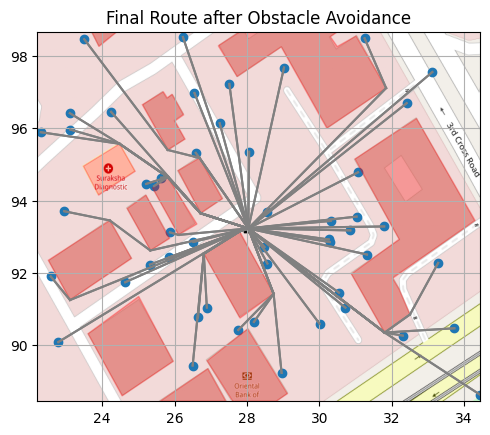

In [1314]:
plot_initial_route(final_dp,delivary_loc, obstacles, final_route, "Final Route after Obstacle Avoidance")

## Hold

#### Enhancement of dp

In [1315]:
print(n)
print(len(obstacles))
print(initial_dist)
print(min_distance)
print(geometric_dist)

50
13
383.412440165084
399.3538807767996
398.079868885827


In [1316]:
import pandas as pd

df = pd.read_csv('./drone_performance_on_obstacles.csv')

new_row = {
    'delivary_locations':n,
    'drone_capacity':1,
    'obstacles':len(obstacles),
    'obstacle_free_distance':initial_dist,
    'distance_after_obstacle_avoidance':min_distance,
    'distance_after_dp_optimization':geometric_dist
}

df.loc[len(df)] = new_row

df.tail(5)

,delivary_locations,drone_capacity,obstacles,obstacle_free_distance,distance_after_obstacle_avoidance,distance_after_dp_optimization
13,40,1,13,325.410146,339.594035,338.197823
14,40,1,13,318.221430,333.087008,331.435911
15,50,1,13,427.114656,438.020969,437.926781
16,50,1,13,425.728717,451.940699,451.678644
17,50,1,13,383.412440,399.353881,398.079869


In [1317]:
try:
    df.to_csv('./drone_performance_on_obstacles.csv', index=False)
except:
    print("Unknown error occurs")